# Fundus Transfer‑Learning Pipeline

## Setup

In [46]:
import os, sys, random
SEED = 42
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    import timm, gdown, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import DataLoader
    from tqdm import tqdm
    from sklearn.metrics import confusion_matrix, classification_report
except ImportError:
    os.system(f"{sys.executable} -m pip install --quiet torch torchvision timm gdown pandas numpy matplotlib seaborn scikit-learn tqdm")
    import timm, gdown, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import DataLoader
    from tqdm import tqdm
    from sklearn.metrics import confusion_matrix, classification_report

torch.backends.cudnn.benchmark = True

### Hyperparameters

**These hyper parameters have been learnt after hyper parameter tuning that is stated later in this notebook.**

In [2]:
NUM_EPOCHS    = 6
BASE_LR       = 3e-5
WEIGHT_DECAY  = 1e-4
BATCH_SIZE    = 16

## Data Import

In [13]:
if not os.path.isdir("color-fundus-eye"):
    os.system("apt-get update -qq && apt-get install -qq git-lfs")
    os.system("git lfs install")
    os.system("git clone https://huggingface.co/datasets/Peacein/color-fundus-eye")


In [16]:
import os

base = "color-fundus-eye"

if os.path.isdir(os.path.join(base, "train")):
    DATA_DIR = base
elif os.path.isdir(os.path.join(base, base, "train")):
    DATA_DIR = os.path.join(base, base)
else:
    raise FileNotFoundError(f"Cannot find 'train' under {base} or {base}/{base}")

train_dir = os.path.join(DATA_DIR, "train")
test_dir  = os.path.join(DATA_DIR, "test")

classes     = sorted(os.listdir(train_dir))
num_classes = len(classes)

n_train = sum(len(files) for _,_,files in os.walk(train_dir))
n_test  = sum(len(files) for _,_,files in os.walk(test_dir))
print(f"DATA_DIR    = {DATA_DIR}")
print(f"Detected {num_classes} classes: {classes}")
print(f"Train dir   = {train_dir} ({n_train} images)")
print(f"Test dir    = {test_dir} ({n_test} images)")

DATA_DIR    = color-fundus-eye
Detected 10 classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']
Train dir   = color-fundus-eye/train (12989 images)
Test dir    = color-fundus-eye/test (3253 images)


## Model

### Model Weights

Instantiate & Load the Pretrained Vision Transformer (ViT) with Global Pooling and a Two-Layer MLP Head

1. **Loads** the pretrained RETFound checkpoint (backbone weights only).  
2. **Builds** a ViT model with **global average pooling** enabled.  
3. **Replaces** the original single-layer head with a **two-layer MLP head**.  
4. **Filters & loads** only the matching backbone weights, skipping any `head.*` parameters.  
5. **Interpolates** positional embeddings if needed.  
6. **Initializes** our new head from scratch.

In [14]:
def ensure_repo(name, url):
    if not os.path.isdir(name):
        print(f"Cloning {name} from {url}…")
        os.system(f"git clone {url} {name}")

ensure_repo("RETFound_MAE", "https://huggingface.co/open-eye/RETFound_MAE")
repo_path = os.path.join(os.getcwd(), "RETFound_MAE")
if not os.path.isdir(repo_path):
    raise FileNotFoundError(f"RETFound_MAE not found at {repo_path}")
sys.path.insert(0, repo_path)
print("✔ Added RETFound_MAE to PYTHONPATH")

✔ Added RETFound_MAE to PYTHONPATH


In [15]:
WEIGHTS = "RETFound_cfp_weights.pth"
if not os.path.isfile(WEIGHTS):
    print("Downloading pretrained fundus weights…")
    os.system(f"gdown --quiet --id 1l62zbWUFTlp214SvK6eMwPQZAzcwoeBE -O {WEIGHTS}")
print("✔ Model weights ready:", WEIGHTS)

✔ Model weights ready: RETFound_cfp_weights.pth


In [17]:
import torch.nn as nn
import models_vit
from util.pos_embed import interpolate_pos_embed
from timm.layers import trunc_normal_

checkpoint   = torch.load(WEIGHTS, map_location="cpu", weights_only=False)
ckpt_model   = checkpoint['model']


model = models_vit.__dict__['vit_large_patch16'](
    num_classes=1,
    drop_path_rate=0.2,
    global_pool=True
)

D = model.embed_dim
model.head = nn.Sequential(
    nn.Linear(D, D // 2),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(D // 2, num_classes)
)

sd = model.state_dict()
backbone_weights = {
    k: v for k, v in ckpt_model.items()
    if k in sd and not k.startswith('head.')
}


interpolate_pos_embed(model, ckpt_model)

msg = model.load_state_dict(backbone_weights, strict=False)
print("🔑 Missing keys when loading backbone (expected for new head):", msg.missing_keys)


for module in model.head:
    if hasattr(module, 'reset_parameters'):
        module.reset_parameters()

model.eval()
print("✅ ViT backbone + 2-layer MLP head ready with global pooling enabled")

🔑 Missing keys when loading backbone (expected for new head): ['fc_norm.weight', 'fc_norm.bias', 'head.0.weight', 'head.0.bias', 'head.3.weight', 'head.3.bias']
✅ ViT backbone + 2-layer MLP head ready with global pooling enabled


### Insert Adapter Modules for the “adapters” Transfer Method

In this step, we augment the pretrained Vision Transformer by adding a small “adapter” network inside its forward pass. During adapter-based fine-tuning:

1. **Adapter Architecture** A tiny **bottleneck** MLP that projects down from the embedding dimension `D` to `D/4`, applies a nonlinearity, then projects back to `D`.  
2. **Residual Connection** We wrap the original `forward_features` call and **add** the adapter output back to the backbone features, preserving most pretrained capacity.  
3. **Why Adapters?** Only the adapter parameters (plus final head) are trained—**all** other weights stay frozen—making fine-tuning very parameter-efficient.

In [18]:
from torch import nn

D = model.embed_dim
adapter_dim = D // 4

model.adapter = nn.Sequential(
    nn.Linear(D, adapter_dim),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Linear(adapter_dim, D),
)

_orig_forward = model.forward_features
def forward_with_adapter(x):
    feat = _orig_forward(x)
    return feat + model.adapter(feat)

model.forward_features = forward_with_adapter

print("✅ Adapter inserted into Vision Transformer:", list(model.adapter))

# model.eval()

✅ Adapter inserted into Vision Transformer: [Linear(in_features=1024, out_features=256, bias=True), ReLU(inplace=True), Dropout(p=0.1, inplace=False), Linear(in_features=256, out_features=1024, bias=True)]


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

## Data Wrangling

To handle class imbalance in your fundus dataset:
1. Apply **train/validation transforms** (data augmentation on train only).  
2. Optionally **subsample** a fixed number of images (or use the full set).  
3. Compute **per-class frequencies** and invert them to get **class weights**.  
4. Build a **`WeightedRandomSampler`** so rare classes are drawn more often.  
5. Wrap everything in PyTorch **`DataLoader`**.

In [35]:
import os, random
import torch
from collections import Counter, defaultdict
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base = "color-fundus-eye"
if os.path.isdir(os.path.join(base, "train")):
    DATA_DIR = base
elif os.path.isdir(os.path.join(base, base, "train")):
    DATA_DIR = os.path.join(base, base)
else:
    raise FileNotFoundError(f"Cannot find 'train' under {base}")
train_dir = os.path.join(DATA_DIR, "train")
test_dir  = os.path.join(DATA_DIR, "test")

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

full_train = ImageFolder(train_dir, transform=train_tf)
orig_classes = full_train.classes

drop_class_names = ["Pterygium", "Central Serous Chorioretinopathy [Color Fundus]", "Glaucoma"]
drop_class_names = [cls for cls in drop_class_names if cls in orig_classes]  # Keep only valid classes

if drop_class_names:
    # Build new mapping
    new_classes = [c for c in orig_classes if c not in drop_class_names]
    new_class_to_idx = {c: i for i, c in enumerate(new_classes)}

    filtered = [
        (path, new_class_to_idx[os.path.basename(os.path.dirname(path))])
        for path, _ in full_train.samples
        if os.path.basename(os.path.dirname(path)) not in drop_class_names
    ]

    full_train.samples = filtered
    full_train.targets = [lbl for _, lbl in filtered]
    full_train.classes = new_classes
    full_train.class_to_idx = new_class_to_idx
    num_classes = len(new_classes)

    print(f"Dropped classes {drop_class_names}. New classes → {new_classes}")
else:
    num_classes = len(orig_classes)
    print(f"No classes dropped. Using classes → {orig_classes}")

print(f"Full TRAIN (post-drop): {len(full_train)} images")

TRAIN_SUBSET_SIZE = 10000
if TRAIN_SUBSET_SIZE and TRAIN_SUBSET_SIZE < len(full_train):
    by_label = defaultdict(list)
    for idx, (_, lbl) in enumerate(full_train.samples):
        by_label[lbl].append(idx)

    labels_available = list(by_label.keys())
    per_class = TRAIN_SUBSET_SIZE // len(labels_available)
    min_count = min(len(by_label[l]) for l in labels_available)
    per_class = min(per_class, min_count)
    total_sel = per_class * len(labels_available)
    if total_sel < TRAIN_SUBSET_SIZE:
        print(f"Smallest class has {min_count} samples; sampling {per_class} each → {total_sel} total")

    train_idxs = []
    for lbl in labels_available:
        train_idxs += random.sample(by_label[lbl], per_class)
    full_train_ds = Subset(full_train, train_idxs)
    print(f"Balanced TRAIN subset → {len(full_train_ds)} images ({per_class} per class)")
else:
    full_train_ds = full_train

all_idxs = list(range(len(full_train_ds)))

if isinstance(full_train_ds, Subset):
    base_ds = full_train_ds.dataset
    subset_ids = full_train_ds.indices
    all_labels = [base_ds.samples[i][1] for i in subset_ids]
else:
    all_labels = [lbl for _, lbl in full_train_ds.samples]

train_idxs, val_idxs = train_test_split(
    all_idxs,
    train_size=0.8,
    random_state=123,
    stratify=all_labels
)
train_ds = Subset(full_train_ds, train_idxs)
val_ds = Subset(full_train_ds, val_idxs)
print(f"▶ Train split: {len(train_ds)} images")
print(f"▶ Val   split: {len(val_ds)} images")

test_ds = ImageFolder(test_dir, transform=val_tf)
print(f"▶ Held-out TEST : {len(test_ds)} images")

BATCH_SIZE = 16
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(f"DataLoaders → Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

def unwrap_subset(ds):
    if isinstance(ds, Subset):
        base, idxs = unwrap_subset(ds.dataset)
        return base, [idxs[i] for i in ds.indices]
    else:
        return ds, list(range(len(ds)))

base_ds, subset_idxs = unwrap_subset(train_ds)
labels_list = [base_ds.samples[i][1] for i in subset_idxs]

counts = Counter(labels_list)

class_weights = torch.zeros(num_classes, dtype=torch.float, device=device)
for cls_idx, cnt in counts.items():
    class_weights[cls_idx] = 1.0 / cnt

print("Computed class_weights:", class_weights)


Dropped classes ['Pterygium', 'Central Serous Chorioretinopathy [Color Fundus]', 'Glaucoma']. New classes → ['Diabetic Retinopathy', 'Disc Edema', 'Healthy', 'Macular Scar', 'Myopia', 'Retinal Detachment', 'Retinitis Pigmentosa']
Full TRAIN (post-drop): 10120 images
⚠️ Smallest class has 600 samples; sampling 600 each → 4200 total
Balanced TRAIN subset → 4200 images (600 per class)
▶ Train split: 3360 images
▶ Val   split: 840 images
▶ Held-out TEST : 3253 images
DataLoaders → Train: 3360, Val: 840, Test: 3253
Computed class_weights: tensor([0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021],
       device='cuda:0')


## Transfer-Learning

This function freezes or unfreezes parts of the Vision Transformer (ViT) backbone according to the chosen transfer-learning method:

1. **`linear_probe`**:  
   - Freeze **all** layers except the final classification head.  
   - Only the head’s weights are updated.

2. **`partial_ft`**:  
   - Freeze the **early** transformer blocks.  
   - Unfreeze the **last `partial_blocks`** transformer blocks plus the head.

3. **`full_ft`**:  
   - Unfreeze **all** model parameters for end-to-end fine-tuning.

4. **`adapters`**:  
   - Freeze the backbone **completely**.  
   - Unfreeze only the small **adapter** modules and the head.

Any other method name raises an error to prevent silent misconfiguration.


In [36]:
def apply_transfer_config(model, method, partial_blocks=4):
    """
    Configures which parameters are trainable based on the transfer method.

    Args:
        model:     The VisionTransformer with optional adapters inserted.
        method:    One of 'linear_probe', 'partial_ft', 'full_ft', or 'adapters'.
        partial_blocks: Number of final transformer blocks to unfreeze in 'partial_ft'.
    """
    for p in model.parameters():
        p.requires_grad = False

    if method == 'linear_probe':
        for p in model.head.parameters():
            p.requires_grad = True

    elif method == 'partial_ft':
        for blk in model.blocks[-partial_blocks:]:
            for p in blk.parameters():
                p.requires_grad = True
        for p in model.head.parameters():
            p.requires_grad = True

    elif method == 'full_ft':
        for p in model.parameters():
            p.requires_grad = True

    elif method == 'adapters':
        for name, p in model.named_parameters():
            if name.startswith('adapter') or name.startswith('head'):
                p.requires_grad = True

    else:
        raise ValueError(f"Unknown transfer-learning method '{method}'")

### 9) Single‐Run Experiment & Detailed CSV Logging

This cell defines the core function `run_single`, which orchestrates one full transfer‐learning experiment for a given method. It will:

1. **Re‐instantiate the Vision Transformer (ViT) backbone**  
   - Creates a fresh model instance to avoid cross‐contamination between experiments.  
   - Loads pretrained weights (excluding any classification head) via positional‐embedding interpolation.

2. **Optionally inject Adapters**  
   - If `method == 'adapters'`, we copy in the lightweight adapter module and override `forward_features` to sum adapter outputs.

3. **Freeze or unfreeze layers**  
   - Uses `apply_transfer_config` to set `requires_grad` flags according to the chosen method:  
     - **Linear Probe**: Only the head.  
     - **Partial Fine‐Tune**: Last few Transformer blocks + head.  
     - **Full Fine‐Tune**: All layers.  
     - **Adapters**: Only adapter + head.

4. **Move model to the compute device** (GPU if available, else CPU).  
   - Sets up **optimizer** (Adam) filtering only trainable parameters.  
   - Defines **loss** using `CrossEntropyLoss`, optionally weighted by inverse class frequencies for imbalance.

5. **Mixup/CutMix augmentation**  
   - Configured to apply to 50% of batches with label smoothing, enhancing robustness.

6. **Per‐epoch logging**  
   - Creates (or overwrites) a CSV file `phase3_exp{exp_no}_{method}_epochs.csv`.  
   - After each epoch, appends the training loss and validation accuracy for detailed curve analysis.

7. **Master summary logging**  
   - After all epochs, calculates total elapsed time.  
   - Appends a single row to `fundus_transfer_experiments.csv` summarizing:  
     - Experiment number (`exp_no`)  
     - Method name (`method`)  
     - Final validation accuracy  
     - Final training loss  
     - Total time in seconds  
     - Timestamp (YYYYMMDD_HHMMSS)

8. **Return values**  
   - Returns the fine‐tuned model (`tmp`) and its per‐epoch history dictionary for downstream visualization.

By encapsulating everything in `run_single`, you can easily loop over multiple methods, hyperparameter settings, or dataset subsets, and accumulate all metrics in a consistent, reproducible format.


In [37]:
from datetime import datetime
import csv, time, os, pandas as pd
import torch.nn as nn
from timm.data import Mixup
from tqdm import tqdm

SUMMARY_CSV    = "fundus_transfer_experiments.csv"
SUMMARY_FIELDS = ['exp_no', 'method', 'val_acc', 'train_loss', 'time_s', 'timestamp']

if not os.path.isfile(SUMMARY_CSV):
    with open(SUMMARY_CSV, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=SUMMARY_FIELDS)
        writer.writeheader()

def run_single(exp_no, method):
    """
    Run one transfer‐learning experiment and log detailed metrics.

    Args:
        exp_no (int):   Identifier for this experiment (used in CSV).
        method (str):   One of ['linear_probe','partial_ft','full_ft','adapters'].

    Returns:
        tmp (nn.Module): The fine‐tuned model after NUM_EPOCHS.
        history (dict):  {'loss': [...], 'val_acc': [...]} per epoch.
    """

    tmp = models_vit.__dict__['vit_large_patch16'](
        num_classes=num_classes,
        drop_path_rate=0.2
    )
    interpolate_pos_embed(tmp, ckpt_model)
    filtered_ckpt = {k: v for k, v in ckpt_model.items() if k in tmp.state_dict()}
    tmp.load_state_dict(filtered_ckpt, strict=False)

    if method == 'adapters':
        tmp.adapter = model.adapter
        orig_forward = tmp.forward_features
        def forward_with_tmp_adapter(x):
            feat = orig_forward(x)
            return feat + tmp.adapter(feat)
        tmp.forward_features = forward_with_tmp_adapter

    apply_transfer_config(tmp, method)

    tmp = tmp.to(device)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, tmp.parameters()),
        lr=BASE_LR,
        weight_decay=WEIGHT_DECAY
    )
    crit = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # # --- Mixup/CutMix augmentation setup ---
    # mixup_fn = Mixup(
    #     mixup_alpha=0.2,
    #     cutmix_alpha=1.0,
    #     prob=0.5,
    #     switch_prob=0.5,
    #     mode='batch',
    #     label_smoothing=0.1,
    #     num_classes=num_classes
    # )

    # --- Prepare per‐epoch CSV file ---
    epoch_csv  = f"phase3_exp{exp_no}_{method}_epochs.csv"
    epoch_cols = ['epoch', 'train_loss', 'val_acc']
    pd.DataFrame(columns=epoch_cols).to_csv(epoch_csv, index=False)

    print(f"\n▶ Experiment #{exp_no} — method={method}")
    start_time = time.time()

    history = {'loss': [], 'val_acc': []}
    for epoch in range(1, NUM_EPOCHS + 1):
        # ---- Training pass ----
        tmp.train()
        running_loss = 0.0
        for imgs, labels in tqdm(train_loader,
                                 desc=f"[{method}] E{epoch}/{NUM_EPOCHS} train",
                                 leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            # imgs, labels = mixup_fn(imgs, labels)  # apply Mixup/CutMix
            optimizer.zero_grad()
            loss = crit(tmp(imgs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        history['loss'].append(avg_loss)

        tmp.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = tmp(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        history['val_acc'].append(val_acc)

        print(f"  Epoch {epoch}/{NUM_EPOCHS} ▶ "
              f"Train Loss: {avg_loss:.4f} — Val Acc: {val_acc:.4%}")

        pd.DataFrame([{
            'epoch': epoch,
            'train_loss': avg_loss,
            'val_acc': val_acc
        }]).to_csv(epoch_csv, mode='a', header=False, index=False)

    elapsed = time.time() - start_time
    summary = {
        'exp_no':     exp_no,
        'method':     method,
        'val_acc':    history['val_acc'][-1],
        'train_loss': history['loss'][-1],
        'time_s':     round(elapsed, 2),
        'timestamp':  datetime.now().strftime('%Y%m%d_%H%M%S'),
    }
    with open(SUMMARY_CSV, 'a', newline='') as f:
        csv.DictWriter(f, fieldnames=SUMMARY_FIELDS).writerow(summary)

    print(f">>> Logged exp#{exp_no} [{method}] → final Val Acc: {summary['val_acc']:.4%}")
    return tmp, history


## 10) Execute All Transfer‐Learning Experiments

In this step, we will:

1. **Prepare containers**  
   - `all_models`: to store the final fine-tuned model from each method.  
   - `all_histories`: to store per-epoch training and validation metrics for each method.

2. **Define the methods**  
   We will run four transfer-learning strategies:
   - **`linear_probe`**: freeze the backbone, train only the head.  
   - **`partial_ft`**: fine-tune the last few Transformer blocks + head.  
   - **`full_ft`**: fine-tune the entire network.  
   - **`adapters`**: keep backbone frozen but train lightweight adapter layers + head.

3. **Run the experiments in a loop**  
   For each `(exp_no, method)`, call `run_single`, log the final accuracy and loss, and save the resulting model and its history.

4. **Final confirmation**  
   After all experiments complete, check `fundus_transfer_experiments.csv` for the summary of results.


In [38]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

all_models     = {}
all_histories  = {}

methods = ['full_ft'] #'linear_probe', 'partial_ft', 'full_ft', 'adapters'

for exp_no, method in enumerate(methods, start=1):
    print(f"\n=== Experiment #{exp_no}: {method} ===")
    model_ft, history = run_single(exp_no=exp_no, method=method)
    all_models[method]    = model_ft
    all_histories[method] = history

    final_acc  = history['val_acc'][-1]
    final_loss = history['loss'][-1]
    print(f">>> {method}: Final Val Acc = {final_acc:.4%}, Final Train Loss = {final_loss:.4f}")

print("\n All 4 experiments complete! Check 'fundus_transfer_experiments.csv' for aggregated results.")

Using device: cuda

=== Experiment #1: full_ft ===

▶ Experiment #1 — method=full_ft


  Epoch 1/6 ▶ Train Loss: 1.3389 — Val Acc: 67.0238%


  Epoch 2/6 ▶ Train Loss: 0.6814 — Val Acc: 84.5238%


  Epoch 3/6 ▶ Train Loss: 0.4129 — Val Acc: 88.0952%


  Epoch 4/6 ▶ Train Loss: 0.3162 — Val Acc: 89.1667%


  Epoch 5/6 ▶ Train Loss: 0.2861 — Val Acc: 90.3571%


  Epoch 6/6 ▶ Train Loss: 0.2392 — Val Acc: 90.9524%
>>> Logged exp#1 [full_ft] → final Val Acc: 90.9524%
>>> full_ft: Final Val Acc = 90.9524%, Final Train Loss = 0.2392

✅ All 4 experiments complete! Check 'fundus_transfer_experiments.csv' for aggregated results.


### 11) Hyperparameter Grid Search

In this phase, we systematically explore combinations of key hyperparameters to find the best settings for each transfer‐learning method.  

**What we sweep:**  
- **Learning Rate (LR):** step size during optimization.  
- **Weight Decay (WD):** L2 regularization strength.  
- **Batch Size (BS):** number of samples per gradient update.

**Grid:**  
- LR ∈ {1e-4, 5e-5, 3e-5, 1e-5}  
- WD ∈ {1e-3, 1e-4, 1e-5}  
- BS ∈ {8, 16, 32}

**Procedure for each (lr, wd, bs, method):**  
1. **Update global hyperparameters** (`BASE_LR`, `WEIGHT_DECAY`, `BATCH_SIZE`).  
2. **Rebuild** `train_loader` and `val_loader` with the new batch size.  
3. **Run** `run_single(exp_no=100, method=method)` to fine-tune and evaluate.  
4. **Record** the final validation accuracy, training loss, and elapsed time.  
5. **Append** a row to `hp_tuning_results.csv`.

> **Defaults (used earlier in baseline runs):**  
> - `BASE_LR = 3e-5`  
> - `WEIGHT_DECAY = 1e-4`  
> - `BATCH_SIZE = 16`  

You can adjust the lists above to include more (or fewer) values.  
Run this cell **after** your baseline experiments (cell 10).

In [ ]:
# import pandas as pd
# from itertools import product
# from datetime import datetime
# from torch.utils.data import DataLoader
# import time

# lrs         = [1e-4, 5e-5, 3e-5, 1e-5]
# wds         = [1e-3, 1e-4, 1e-5]
# batch_sizes = [8, 16, 32]

# HP_CSV    = "hp_tuning_results.csv"
# hp_fields = ["lr","wd","batch_size","method","val_acc","train_loss","time_s","timestamp"]
# pd.DataFrame(columns=hp_fields).to_csv(HP_CSV, index=False)

# print("▶ Starting hyperparameter grid search…")
# for lr, wd, bs in product(lrs, wds, batch_sizes):
#     for method in methods:
#         BASE_LR      = lr
#         WEIGHT_DECAY = wd
#         BATCH_SIZE   = bs

#         train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
#                                   num_workers=4, pin_memory=True)
#         val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
#                                   num_workers=4, pin_memory=True)

#         print(f"\n--- HP Sweep: lr={lr}, wd={wd}, bs={bs}, method={method} ---")
#         start_time = time.time()
#         model_ft, history = run_single(exp_no=100, method=method)
#         elapsed = time.time() - start_time

#         val_acc    = history["val_acc"][-1]
#         train_loss = history["loss"][-1]

#         row = {
#             "lr": lr,
#             "wd": wd,
#             "batch_size": bs,
#             "method": method,
#             "val_acc": val_acc,
#             "train_loss": train_loss,
#             "time_s": round(elapsed, 2),
#             "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S")
#         }
#         pd.DataFrame([row]).to_csv(HP_CSV, mode="a", header=False, index=False)

# print("Hyperparameter sweep complete! Results saved to", HP_CSV)


### Saving Model

In [39]:
import torch

best_method = max(all_histories.items(),
                  key=lambda kv: kv[1]['val_acc'][-1])[0]
best_model  = all_models[best_method]
best_acc    = all_histories[best_method]['val_acc'][-1]

fname = f"best_model_{best_method}_{int(best_acc*10000):04d}.pth"
torch.save(best_model.state_dict(), fname)
print(f"✔ Saved best model ({best_method}) with val_acc={best_acc:.4%} to {fname}")

✔ Saved best model (full_ft) with val_acc=90.9524% to best_model_full_ft_9095.pth


### Evaluation

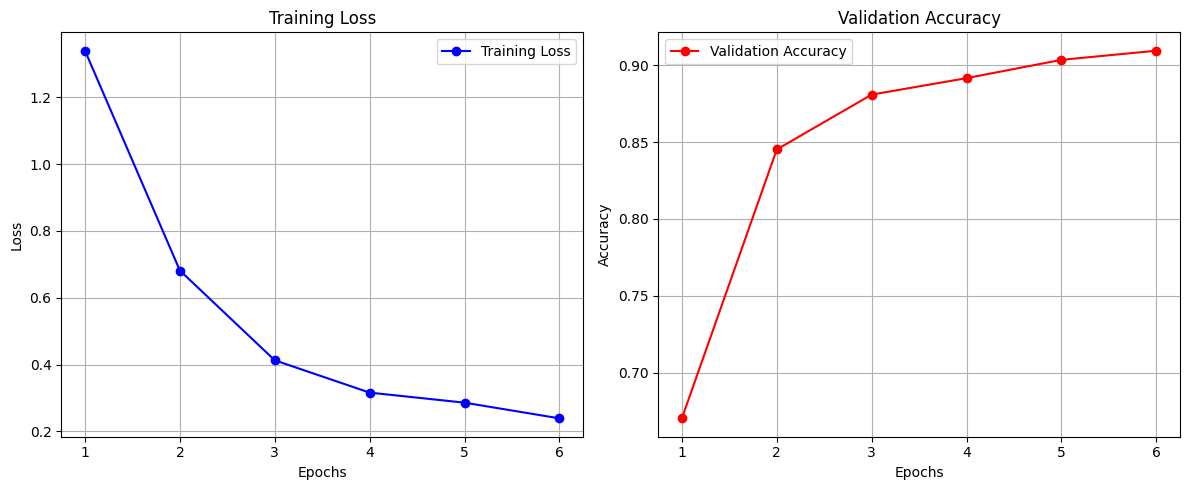

In [42]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    history: dict containing 'loss' and 'val_acc' lists.
    Plots training loss and validation accuracy curves.
    """
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)


Dropped classes ['Pterygium', 'Central Serous Chorioretinopathy [Color Fundus]', 'Glaucoma'] from test set, remaining classes → ['Diabetic Retinopathy', 'Disc Edema', 'Healthy', 'Macular Scar', 'Myopia', 'Retinal Detachment', 'Retinitis Pigmentosa']
Classification Report
                       precision    recall  f1-score   support

Diabetic Retinopathy       0.98      0.92      0.95       689
          Disc Edema       0.92      0.99      0.95       153
             Healthy       0.91      0.89      0.90       536
        Macular Scar       0.79      0.87      0.83       388
              Myopia       0.91      0.85      0.88       451
  Retinal Detachment       0.97      0.97      0.97       150
Retinitis Pigmentosa       0.84      0.99      0.91       167

            accuracy                           0.91      2534
           macro avg       0.90      0.93      0.91      2534
        weighted avg       0.91      0.91      0.91      2534



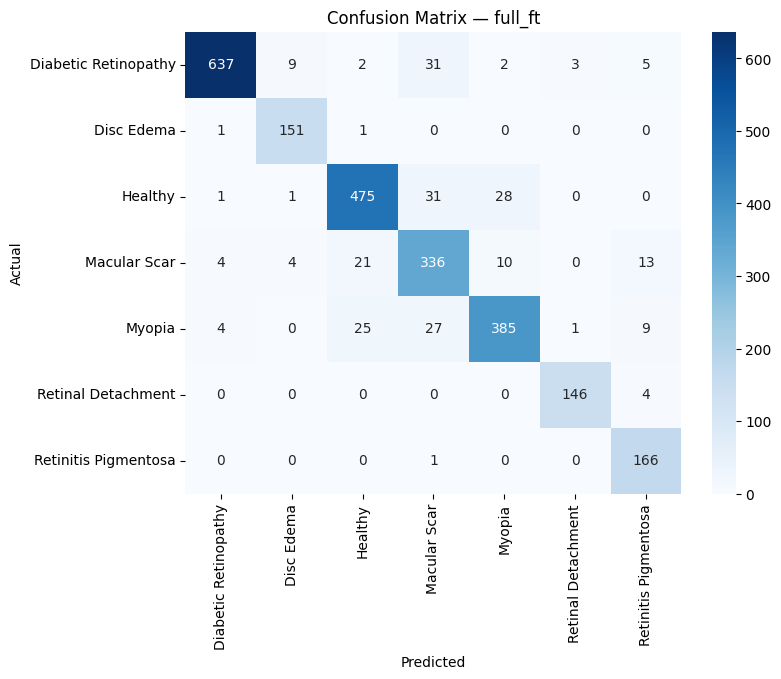

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os

drop_class_names = ["Pterygium", "Central Serous Chorioretinopathy [Color Fundus]", "Glaucoma"]
# drop_class_names = drop_class_names
test_ds = test_loader.dataset

if isinstance(test_ds, torch.utils.data.Subset):
    test_ds = test_ds.dataset

drop_indices = [test_ds.class_to_idx[cls] for cls in drop_class_names if cls in test_ds.classes]

new_classes = [c for c in test_ds.classes if c not in drop_class_names]
new_class_to_idx = {c: i for i, c in enumerate(new_classes)}

filtered = [
    (path, new_class_to_idx[os.path.basename(os.path.dirname(path))])
    for path, lbl in test_ds.samples
    if lbl not in drop_indices
]

test_ds.samples = filtered
test_ds.targets = [lbl for _, lbl in filtered]
test_ds.classes = new_classes
test_ds.class_to_idx = new_class_to_idx
classes = new_classes

print(f"Dropped classes {drop_class_names} from test set, remaining classes → {classes}")

test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=test_loader.batch_size, shuffle=False,
    num_workers=test_loader.num_workers, pin_memory=True
)

best_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = best_model(imgs)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

print("Classification Report\n",
      classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix — {best_method}")
plt.show()


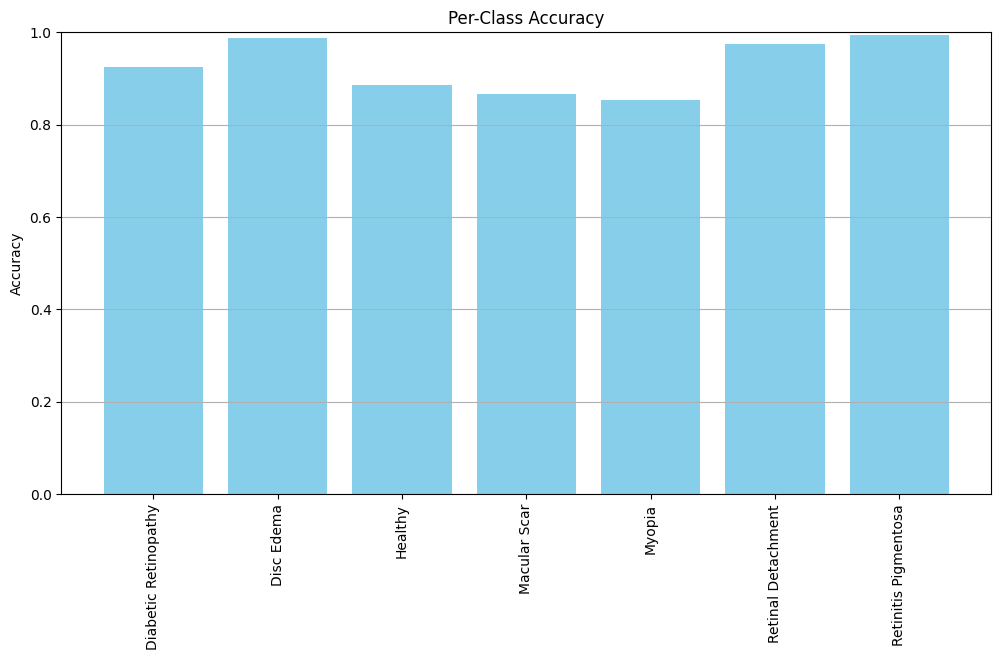

In [47]:
import numpy as np

# Calculate per-class accuracy
cm = confusion_matrix(all_labels, all_preds)
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(12,6))
plt.bar(classes, class_acc, color='skyblue')
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.grid(axis='y')
plt.show()


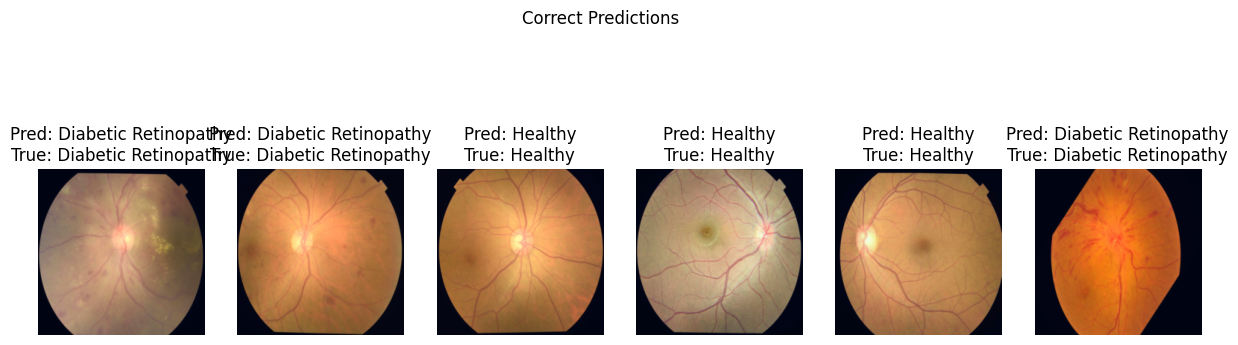

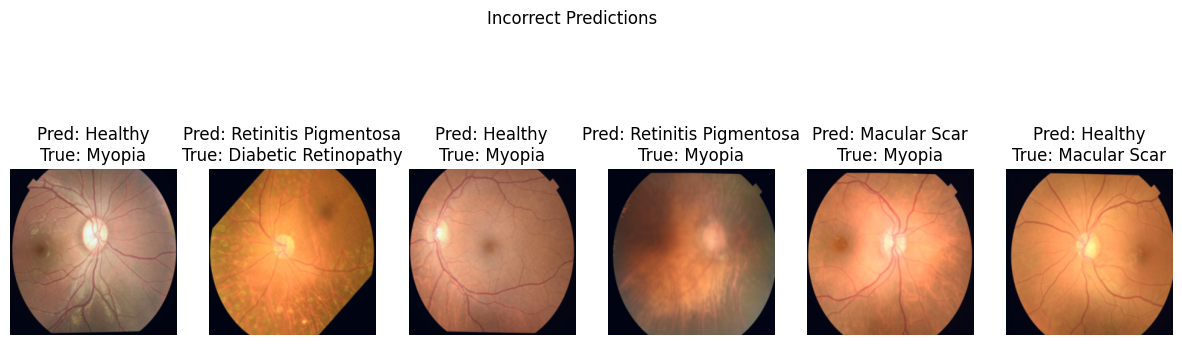

In [48]:
import random

# Collect (img, pred, label) triples
samples = []
best_model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = best_model(imgs)
        preds = logits.argmax(dim=1)
        for img, pred, label in zip(imgs.cpu(), preds.cpu(), labels.cpu()):
            samples.append((img, pred.item(), label.item()))

# Pick random correct and incorrect examples
correct = [(img, pred, label) for img, pred, label in samples if pred == label]
incorrect = [(img, pred, label) for img, pred, label in samples if pred != label]

def plot_examples(example_list, title, n=6):
    plt.figure(figsize=(15,5))
    for i, (img, pred, label) in enumerate(random.sample(example_list, min(n, len(example_list)))):
        plt.subplot(1, n, i+1)
        img = img.permute(1,2,0)  # C,H,W → H,W,C
        img = (img - img.min()) / (img.max() - img.min())  # normalize
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {classes[pred]}\nTrue: {classes[label]}")
    plt.suptitle(title)
    plt.show()

plot_examples(correct, "Correct Predictions")
plot_examples(incorrect, "Incorrect Predictions")


Grad-CAM and Grad-CAM++ visualizations for correct and incorrect predictions
Below are the visualizations generated using the Grad-CAM and Grad-CAM++ techniques for selected examples from the validation set.


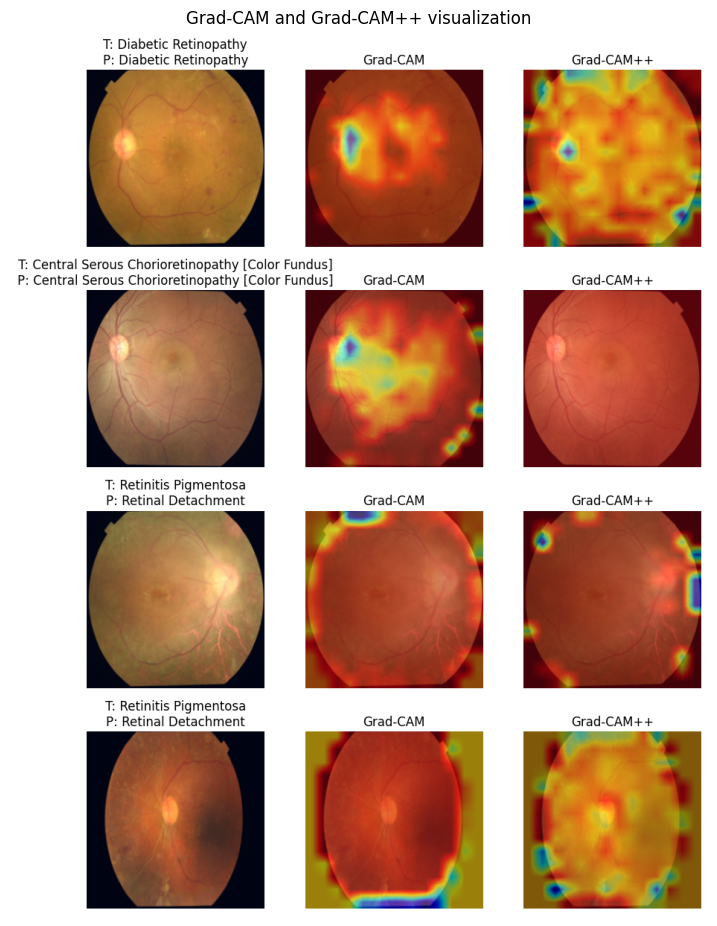

In [ ]:

# Grad-CAM gallery: 2 correct + 2 incorrect examples (fixed colormap arg)
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

# 1) Cache all val images, labels & preds
all_imgs, all_labels, all_preds = [], [], []
best_model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits = best_model(imgs)
        preds = logits.argmax(dim=1)
        all_imgs.extend(imgs.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 2) Split correct vs incorrect
correct_idxs   = [i for i,(l,p) in enumerate(zip(all_labels, all_preds)) if l==p]
incorrect_idxs = [i for i,(l,p) in enumerate(zip(all_labels, all_preds)) if l!=p]

# 3) Pick 2 of each
random.seed(42)
sel = random.sample(correct_idxs,   2) + random.sample(incorrect_idxs, 2)

# 4) Hook up CAMs on the conv layer that actually sees H×W
target_layer = best_model.patch_embed.proj
cam    = GradCAM(model=best_model,    target_layers=[target_layer])
cam_pp = GradCAMPlusPlus(model=best_model, target_layers=[target_layer])

# 5) Plot 4×3 grid: original / Grad-CAM / Grad-CAM++
fig, axes = plt.subplots(4, 3, figsize=(9, 12))
for row, idx in enumerate(sel):
    img_t = all_imgs[idx]     # tensor [3,224,224]
    lbl   = all_labels[idx]
    pr    = all_preds[idx]

    # prepare image for display
    img_np = img_t.permute(1,2,0).numpy()
    img_np = (img_np - img_np.min())/(img_np.max()-img_np.min())

    # compute masks
    mask     = cam(input_tensor=img_t.unsqueeze(0).to(device))[0]
    mask_pp  = cam_pp(input_tensor=img_t.unsqueeze(0).to(device))[0]

    # col 1: original
    ax = axes[row, 0]
    ax.imshow(img_np)
    ax.set_title(f"T: {classes[lbl]}\nP: {classes[pr]}")
    ax.axis('off')

    # col 2: Grad-CAM
    ax = axes[row, 1]
    overlay = show_cam_on_image(img_np, mask, colormap=cv2.COLORMAP_JET)
    ax.imshow(overlay)
    ax.set_title("Grad-CAM")
    ax.axis('off')

    # col 3: Grad-CAM++
    ax = axes[row, 2]
    overlay2 = show_cam_on_image(img_np, mask_pp, colormap=cv2.COLORMAP_JET)
    ax.imshow(overlay2)
    ax.set_title("Grad-CAM++")
    ax.axis('off')

plt.tight_layout()
plt.show()



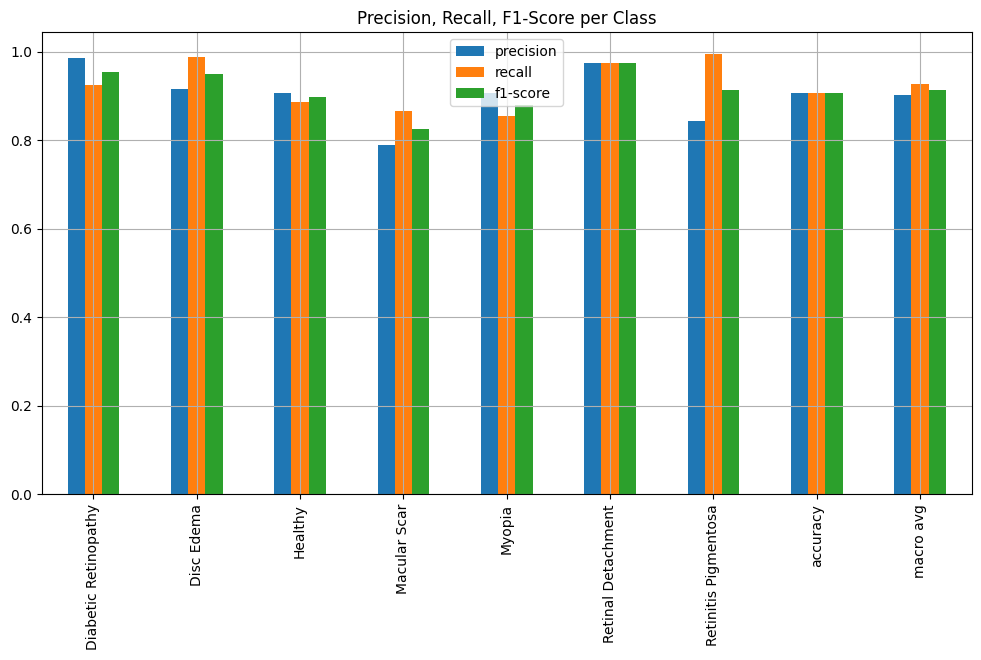

In [55]:
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-1, :3].plot(kind='bar', figsize=(12,6))
plt.title('Precision, Recall, F1-Score per Class')
plt.grid()
plt.show()